Baseline: 5 files, 24990 samples
Prediction-only: 5 files, 33424 samples
Closed-loop: 5 files, 41489 samples

=== System Latency Summary ===
           Mode     N  Mean_ms   Std_ms  p50_ms   p95_ms    p99_ms  Max_ms
       Baseline 24990 1.591085 0.893466 1.53665 2.792355  4.058154 79.8308
Prediction-only 33424 5.629717 1.550235 5.53845 8.234225 10.436647 30.3934
    Closed-loop 41489 6.559487 1.794844 6.40540 9.741720 11.752504 21.4638

Plot saved to: D:\PredictionUpdated_Dataset\Article _Results_Plots\fig_system_latency_cdf_Plot.pdf


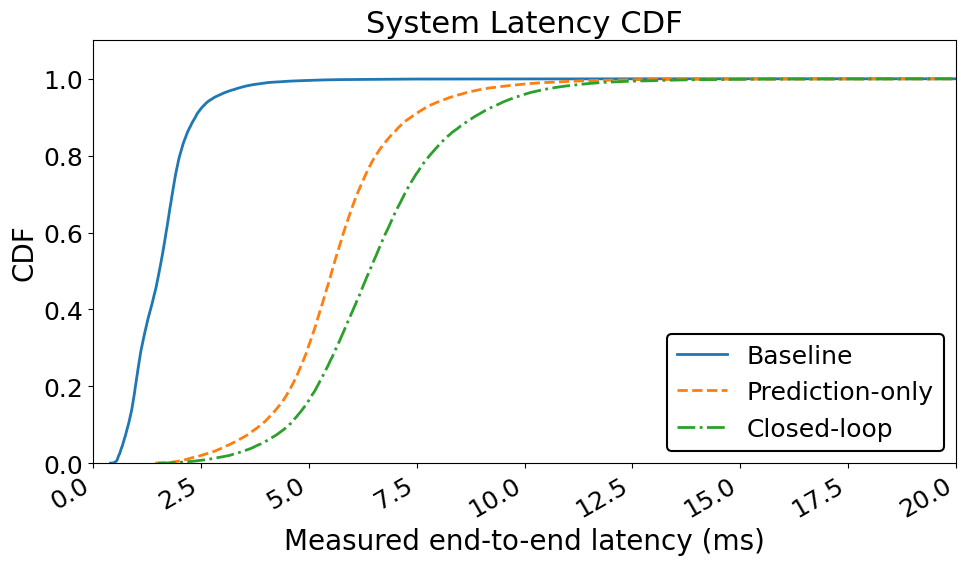

In [43]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = r"D:\PredictionUpdated_Dataset"

# >>> SAVE DIRECTORY <<<
SAVE_DIR = r"D:\PredictionUpdated_Dataset\Article _Results_Plots"
os.makedirs(SAVE_DIR, exist_ok=True)

MODES = {
    "Baseline": "Baseline",
    "Prediction-only": "Prediction-only",
    "Closed-loop": "Closed-loop",
}

LAT_COL = "measured_latency_ms"
DEADLINE_MS = None

# ===== PLOT STYLE =====
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "font.size": 18,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18,
    "lines.linewidth": 2,
})

X_TICK_ROTATION = 30

# ===== LOAD DATA =====
mode_latency = {}

for label, folder in MODES.items():
    path = os.path.join(ROOT, folder)
    files = sorted(glob.glob(os.path.join(path, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files found in {path}")

    latencies = []
    for f in files:
        df = pd.read_csv(f)
        # be robust to whitespace in headers
        df.columns = [str(c).strip() for c in df.columns]

        if LAT_COL not in df.columns:
            raise KeyError(f"{LAT_COL} not found in {f}. Columns: {list(df.columns)}")

        lat = pd.to_numeric(df[LAT_COL], errors="coerce").dropna()
        latencies.append(lat)

    lat_all = pd.concat(latencies, ignore_index=True)
    lat_all = lat_all[lat_all >= 0]

    mode_latency[label] = lat_all
    print(f"{label}: {len(files)} files, {len(lat_all)} samples")

# ===== SUMMARY TABLE =====
rows = []
for label, lat in mode_latency.items():
    arr = lat.to_numpy()
    row = {
        "Mode": label,
        "N": len(arr),
        "Mean_ms": np.mean(arr),
        "Std_ms": np.std(arr, ddof=1),
        "p50_ms": np.percentile(arr, 50),
        "p95_ms": np.percentile(arr, 95),
        "p99_ms": np.percentile(arr, 99),
        "Max_ms": np.max(arr),
    }
    if DEADLINE_MS is not None:
        row["MissRate_%"] = np.mean(arr > DEADLINE_MS) * 100
    rows.append(row)

summary_df = pd.DataFrame(rows)
print("\n=== System Latency Summary ===")
print(summary_df.to_string(index=False))

# ===== FIGURE: CDF =====
plt.figure()

# Different line styles (keep colors as matplotlib assigns them)
line_styles = {
    "Baseline": "-",
    "Prediction-only": "--",
    "Closed-loop": "-."
}

for label, lat in mode_latency.items():
    x = np.sort(lat.to_numpy())
    y = np.arange(1, len(x) + 1) / len(x)
    plt.plot(x, y, label=label, linestyle=line_styles[label])

plt.xlabel("Measured end-to-end latency (ms)")
plt.ylabel("CDF")
plt.title("System Latency CDF")

plt.xticks(rotation=X_TICK_ROTATION, ha="right")

# Axis limits: start at zero and zoom to 0–20 ms
plt.xlim(0, 20)
plt.ylim(0, 1.1)

# Legend formatting
legend = plt.legend(
    loc="lower right",
    frameon=True,
    framealpha=1.0,
    edgecolor="black"
)
legend.get_frame().set_linewidth(1.5)

plt.tight_layout()

# >>> SAVE (PDF) <<<
save_path = os.path.join(SAVE_DIR, "fig_system_latency_cdf_Plot.pdf")
plt.savefig(save_path, dpi=300)

print(f"\nPlot saved to: {save_path}")

plt.show()


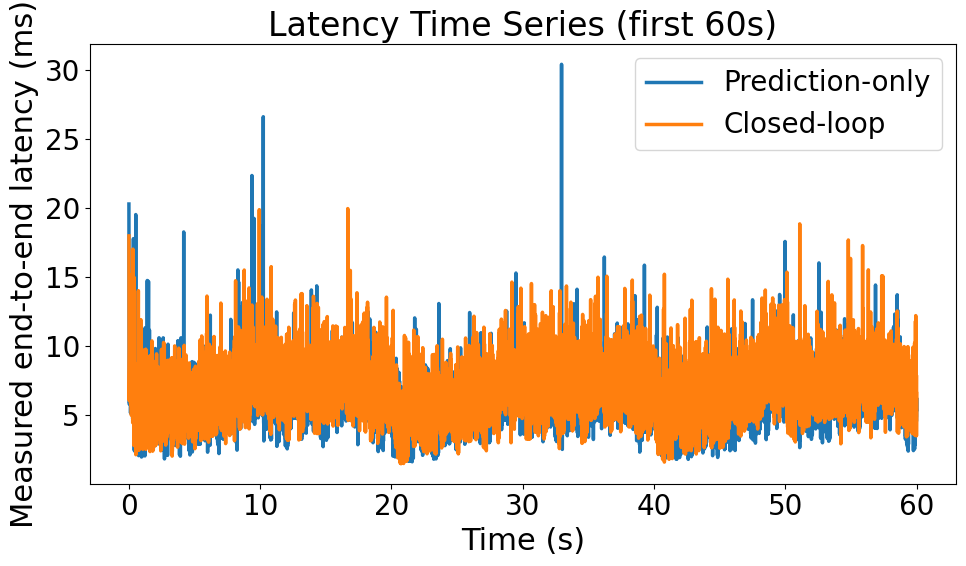

In [13]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = r"D:\PredictionUpdated_Dataset"
PRED_DIR = os.path.join(ROOT, "Prediction-only")
CL_DIR   = os.path.join(ROOT, "Closed-loop")

TIME_COL = "t_unity"
LAT_COL  = "measured_latency_ms"

# pick a window length in seconds
WINDOW_S = 60.0

# ===== STYLE SETTINGS =====
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "font.size": 18,
    "axes.titlesize": 24,
    "axes.labelsize": 22,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 20,
    "lines.linewidth": 2.5,
})

def load_concat(folder):
    files = sorted(glob.glob(os.path.join(folder, "*.csv")))
    if not files:
        raise FileNotFoundError(f"No CSV files in: {folder}")
    dfs = []
    for f in files:
        df = pd.read_csv(f)

        if TIME_COL not in df.columns or LAT_COL not in df.columns:
            raise KeyError(f"Missing {TIME_COL} or {LAT_COL} in {f}")

        df = df[[TIME_COL, LAT_COL]].copy()
        df[TIME_COL] = pd.to_numeric(df[TIME_COL], errors="coerce")
        df[LAT_COL]  = pd.to_numeric(df[LAT_COL], errors="coerce")
        df = df.dropna()
        dfs.append(df)

    out = pd.concat(dfs, ignore_index=True)

    # sort by time, then normalize time to start at 0
    out = out.sort_values(TIME_COL).reset_index(drop=True)
    out[TIME_COL] = out[TIME_COL] - out[TIME_COL].iloc[0]
    return out

pred = load_concat(PRED_DIR)
cl   = load_concat(CL_DIR)

def select_window(df, window_s=60.0, start_s=None):
    if start_s is None:
        start_s = float(df[TIME_COL].iloc[0])
    end_s = start_s + window_s
    w = df[(df[TIME_COL] >= start_s) & (df[TIME_COL] <= end_s)].copy()
    return w, start_s, end_s

pred_w, s1, e1 = select_window(pred, WINDOW_S, start_s=0.0)
cl_w,   s2, e2 = select_window(cl,   WINDOW_S, start_s=0.0)

# ===== PLOT =====
plt.figure()

plt.plot(pred_w[TIME_COL], pred_w[LAT_COL], label="Prediction-only")
plt.plot(cl_w[TIME_COL],   cl_w[LAT_COL],   label="Closed-loop")

plt.xlabel("Time (s)")
plt.ylabel("Measured end-to-end latency (ms)")
plt.title(f"Latency Time Series (first {WINDOW_S:.0f}s)")

plt.legend()
plt.tight_layout()

SAVE_DIR = r"D:\PredictionUpdated_Dataset\Article _Results_Plots"
os.makedirs(SAVE_DIR, exist_ok=True)

save_path = os.path.join(SAVE_DIR, "fig_timeseries_latency_pred_vs_cl.pdf")
plt.savefig(save_path, dpi=300)


plt.show()


Baseline: found 5 CSV files
Prediction-only: found 5 CSV files
Closed-Loop: found 5 CSV files


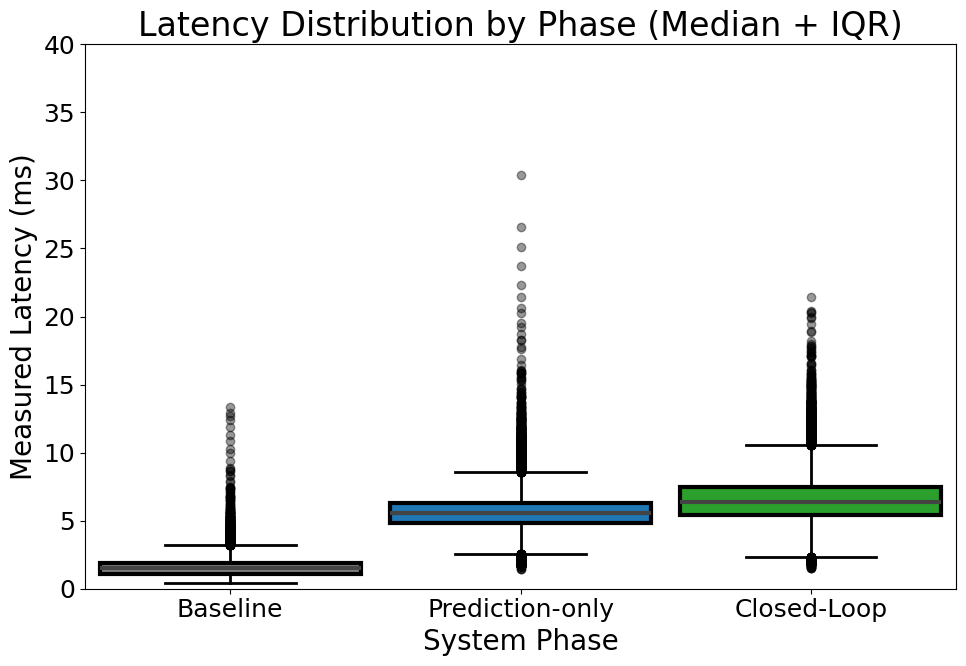

Saved to:
D:\PredictionUpdated_Dataset\Article _Results_Plots\latency_boxplot_all_phases.pdf
D:\PredictionUpdated_Dataset\Article _Results_Plots\latency_boxplot_all_phases.png


In [30]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = r"D:\PredictionUpdated_Dataset"


SAVE_DIR = r"D:\PredictionUpdated_Dataset\Article _Results_Plots"
os.makedirs(SAVE_DIR, exist_ok=True)

PHASES = ["Baseline", "Prediction-only", "Closed-Loop"]

# ===== STYLE SETTINGS =====
plt.rcParams.update({
    "figure.figsize": (10, 7),
    "font.size": 18,
    "axes.titlesize": 24,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

def load_latency_recursive(phase: str) -> np.ndarray:
    phase_folder = os.path.join(ROOT, phase)
    if not os.path.isdir(phase_folder):
        print(f"[WARN] Phase folder not found: {phase_folder}")
        return np.array([])

    pattern = os.path.join(phase_folder, "**", "*.csv")
    files = sorted(glob.glob(pattern, recursive=True))
    print(f"{phase}: found {len(files)} CSV files")

    lat_all = []
    for f in files:
        try:
            df = pd.read_csv(f)
            if "measured_latency_ms" not in df.columns:
                continue

            lat = pd.to_numeric(df["measured_latency_ms"], errors="coerce").dropna().to_numpy()
            lat = lat[np.isfinite(lat)]
            lat = lat[lat >= 0]

            if lat.size > 0:
                lat_all.append(lat)

        except Exception as e:
            print(f"[ERROR] Reading {f}: {e}")

    return np.concatenate(lat_all) if lat_all else np.array([])

# ===== LOAD DATA =====
data = []
labels = []

for phase in PHASES:
    lat = load_latency_recursive(phase)
    if lat.size == 0:
        raise RuntimeError(f"No valid latency data found for {phase}")
    data.append(lat)
    labels.append(phase)

# ===== PLOT =====
plt.figure()


colors = ["#7f7f7f", "#1f77b4", "#2ca02c"]  # gray, blue, green

box = plt.boxplot(
    data,
    labels=labels,
    showfliers=True,
    widths=0.9,
    patch_artist=True
)

for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor("black")
    patch.set_linewidth(3)
    patch.set_alpha(1.0)  
for median in box["medians"]:
    median.set_color("#444444") 
    median.set_linewidth(3)

for whisker in box["whiskers"]:
    whisker.set_color("black")
    whisker.set_linewidth(2)

for cap in box["caps"]:
    cap.set_color("black")
    cap.set_linewidth(2)


# Outliers
for flier in box["fliers"]:
    flier.set(marker='o', markersize=6, markerfacecolor='black', alpha=0.4)

plt.xlabel("System Phase")
plt.ylabel("Measured Latency (ms)")
plt.title("Latency Distribution by Phase (Median + IQR)")

plt.ylim(0, 40)  # <-- Cut measurement axis at 25 ms

plt.tight_layout()


# Correct saving (NO escape problems)
outpath_pdf = os.path.join(SAVE_DIR, "latency_boxplot_all_phases.pdf")
plt.savefig(outpath_pdf)

outpath_png = os.path.join(SAVE_DIR, "latency_boxplot_all_phases.png")
plt.savefig(outpath_png, dpi=300)

plt.show()

print(f"Saved to:\n{outpath_pdf}\n{outpath_png}")


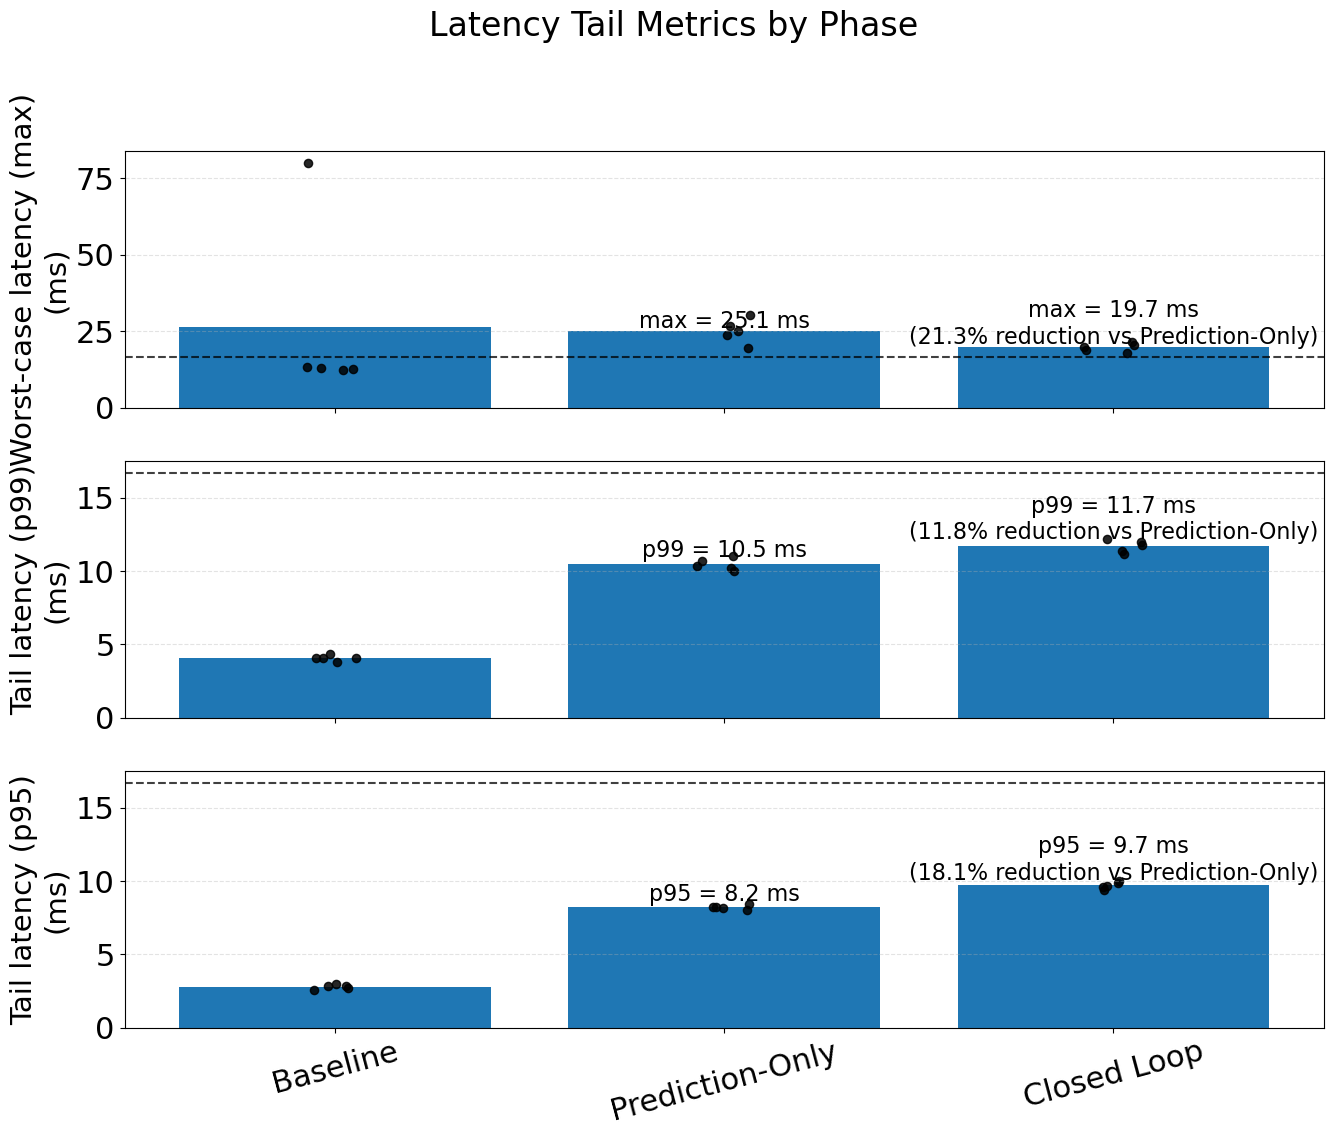

Saved: D:\PredictionUpdated_Dataset\Article _Results_Plots\tail_metrics_panel_with_budget_and_reduction.png
Saved: D:\PredictionUpdated_Dataset\Article _Results_Plots\tail_metrics_panel_with_budget_and_reduction.pdf


In [25]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
ROOT = r"D:\PredictionUpdated_Dataset"
OUTDIR = os.path.join(ROOT, "plots_tail_metrics_percentile")
os.makedirs(OUTDIR, exist_ok=True)

EXPECTED_RUNS_PER_PHASE = 5
LAT_COL = "measured_latency_ms"

FRAME_BUDGET_MS = 16.67
FRAME_BUDGET_LABEL = "60 FPS frame budget (16.67 ms)"


plt.rcParams.update({
    "font.size": 24,
    "axes.titlesize": 22,
    "axes.labelsize": 21,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
})


PHASES = ["Baseline", "Prediction-only", "Closed-loop"]
PHASE_LABELS = {
    "Baseline": "Baseline",
    "Prediction-only": "Prediction-Only",
    "Closed-loop": "Closed Loop",
}


def list_phase_files(phase):
    # all csvs directly inside each phase folder
    return sorted(glob.glob(os.path.join(ROOT, phase, "*.csv")))

def read_latency(fp):
    df = pd.read_csv(fp)

    # Strip header whitespace (common issue)
    df.columns = [str(c).strip() for c in df.columns]

    if LAT_COL not in df.columns:
        print(f"[SKIP] Missing '{LAT_COL}' in: {fp}")
        print(f"       Columns: {list(df.columns)}")
        return np.array([])

    lat = pd.to_numeric(df[LAT_COL], errors="coerce").to_numpy(float)
    lat = lat[np.isfinite(lat)]
    return lat

def pct(x, p):
    return float(np.percentile(x, p)) if x.size else np.nan


rows = []
for phase in PHASES:
    files = list_phase_files(phase)
    if not files:
        raise FileNotFoundError(f"No CSV files found in: {os.path.join(ROOT, phase)}")

    valid_count = 0
    for f in files:
        lat = read_latency(f)
        if lat.size == 0:
            continue

        rows.append({
            "phase": phase,
            "p95": pct(lat, 95),
            "p99": pct(lat, 99),
            "max": float(np.max(lat))
        })

        valid_count += 1
        if valid_count >= EXPECTED_RUNS_PER_PHASE:
            break

    if valid_count < EXPECTED_RUNS_PER_PHASE:
        print(f"[WARN] {phase}: only {valid_count} valid runs found (expected {EXPECTED_RUNS_PER_PHASE}).")

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No valid latency data loaded. Check [SKIP] logs above.")


def plot_panel(df):
    metrics = [("max", "Worst-case latency (max)"),
               ("p99", "Tail latency (p99)"),
               ("p95", "Tail latency (p95)")]

    x = np.arange(len(PHASES))
    fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    rng = np.random.default_rng(0)

    pred_idx, cl_idx = 1, 2

    for ax, (metric, title) in zip(axes, metrics):
        means = [df[df["phase"] == p][metric].mean() for p in PHASES]

        ax.bar(x, means)

        # Per-run dots
        for i, p in enumerate(PHASES):
            vals = df[df["phase"] == p][metric].to_numpy()
            jitter = (rng.random(len(vals)) - 0.5) * 0.15
            ax.scatter(np.full_like(vals, x[i]) + jitter, vals,
                       color="black", s=35, alpha=0.85)

        # Budget line
        ax.axhline(FRAME_BUDGET_MS, linestyle="--", color="black", alpha=0.75)

        pred_val = means[pred_idx]
        cl_val = means[cl_idx]
        reduction = abs(100 * (pred_val - cl_val) / pred_val) if pred_val != 0 else np.nan

        ypad = max(max(means) * 0.04, 0.3)

        # Prediction-Only label
        ax.text(pred_idx, pred_val + ypad,
                f"{metric} = {pred_val:.1f} ms",
                ha="center", fontsize=16)

        # Closed-Loop label (EXPLICIT comparison)
        ax.text(cl_idx, cl_val + ypad,
                f"{metric} = {cl_val:.1f} ms\n({reduction:.1f}% reduction vs Prediction-Only)",
                ha="center", fontsize=16)

        ax.set_ylabel(f"{title}\n(ms)")
        ax.grid(axis="y", linestyle="--", alpha=0.35)

    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels([PHASE_LABELS[p] for p in PHASES], rotation=15)

    fig.suptitle("Latency Tail Metrics by Phase", fontsize=24)
    fig.tight_layout(rect=[0, 0.02, 1, 0.95])

    SAVE_DIR = r"D:\PredictionUpdated_Dataset\Article _Results_Plots"
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    out_png = os.path.join(SAVE_DIR, "tail_metrics_panel_with_budget_and_reduction.png")
    out_pdf = os.path.join(SAVE_DIR, "tail_metrics_panel_with_budget_and_reduction.pdf")
    
    plt.savefig(out_png, dpi=300)
    plt.savefig(out_pdf)
    
    plt.show()
    plt.close()
    
    print("Saved:", out_png)
    print("Saved:", out_pdf)


plot_panel(df)


Saved per-run data: D:\PredictionUpdated_Dataset\Article _Results_Plots\deadline_miss_rate_per_run.csv


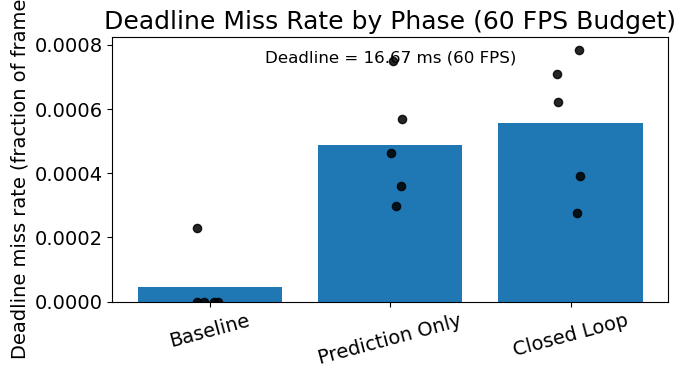

Saved plot: D:\PredictionUpdated_Dataset\Article _Results_Plots\deadline_miss_rate.pdf


In [45]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
ROOT = r"D:\PredictionUpdated_Dataset"
OUTDIR = os.path.join(ROOT, "D:\PredictionUpdated_Dataset\Article _Results_Plots")
os.makedirs(OUTDIR, exist_ok=True)

EXPECTED_RUNS = 5
LAT_COL = "measured_latency_ms"
BUDGET_MS = 16.67   # 60 FPS frame budget

# -----------------------------
# Increase fonts
# -----------------------------
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

# -----------------------------
# ✅ USE ONLY THE THREE DATASET FOLDERS
# -----------------------------
PHASES = ["Baseline", "Prediction-only", "Closed-loop"]
PHASE_LABELS = {
    "Baseline": "Baseline",
    "Prediction-only": "Prediction Only",
    "Closed-loop": "Closed Loop",
}

# -----------------------------
# Helpers
# -----------------------------
def list_phase_files(phase_folder_name):
    return sorted(glob.glob(os.path.join(ROOT, phase_folder_name, "*.csv")))

def compute_miss_rate(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [str(c).strip() for c in df.columns]  # strip spaces in headers

    if LAT_COL not in df.columns:
        print(f"[SKIP] '{LAT_COL}' missing in {csv_path}. Columns: {list(df.columns)}")
        return np.nan

    lat = pd.to_numeric(df[LAT_COL], errors="coerce").to_numpy(float)
    lat = lat[np.isfinite(lat)]
    if lat.size == 0:
        return np.nan

    return float(np.mean(lat > BUDGET_MS))

# -----------------------------
# Compute miss rates
# -----------------------------
rows = []

for phase in PHASES:
    files = list_phase_files(phase)

    if len(files) == 0:
        raise RuntimeError(f"No CSV files found in {os.path.join(ROOT, phase)}")

    use_files = files[:EXPECTED_RUNS]
    if len(use_files) != EXPECTED_RUNS:
        print(f"[WARN] {phase}: expected {EXPECTED_RUNS} runs, found {len(use_files)}")

    for f in use_files:
        miss_rate = compute_miss_rate(f)
        rows.append({
            "phase_folder": phase,
            "phase_label": PHASE_LABELS[phase],
            "run": os.path.basename(f),
            "miss_rate": miss_rate
        })

df = pd.DataFrame(rows)

csv_out = os.path.join(OUTDIR, "deadline_miss_rate_per_run.csv")
df.to_csv(csv_out, index=False)
print("Saved per-run data:", csv_out)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(7, 4))

x = np.arange(len(PHASES))
means = [df[df["phase_folder"] == p]["miss_rate"].mean() for p in PHASES]

plt.bar(x, means)

rng = np.random.default_rng(0)
for i, phase in enumerate(PHASES):
    vals = df[df["phase_folder"] == phase]["miss_rate"].to_numpy(float)
    vals = vals[np.isfinite(vals)]
    jitter = (rng.random(len(vals)) - 0.5) * 0.15
    plt.scatter(np.full_like(vals, x[i], dtype=float) + jitter, vals,
                s=35, color="black", alpha=0.85)

plt.xticks(x, [PHASE_LABELS[p] for p in PHASES], rotation=15)
plt.ylabel("Deadline miss rate (fraction of frames)")
plt.title("Deadline Miss Rate by Phase (60 FPS Budget)")

plt.text(0.5, 0.95, "Deadline = 16.67 ms (60 FPS)",
         transform=plt.gca().transAxes,
         ha="center", va="top", fontsize=12)

plt.tight_layout()
outpath = os.path.join(OUTDIR, "deadline_miss_rate.pdf")
plt.savefig(outpath, dpi=240)
plt.show()
plt.close()

print("Saved plot:", outpath)


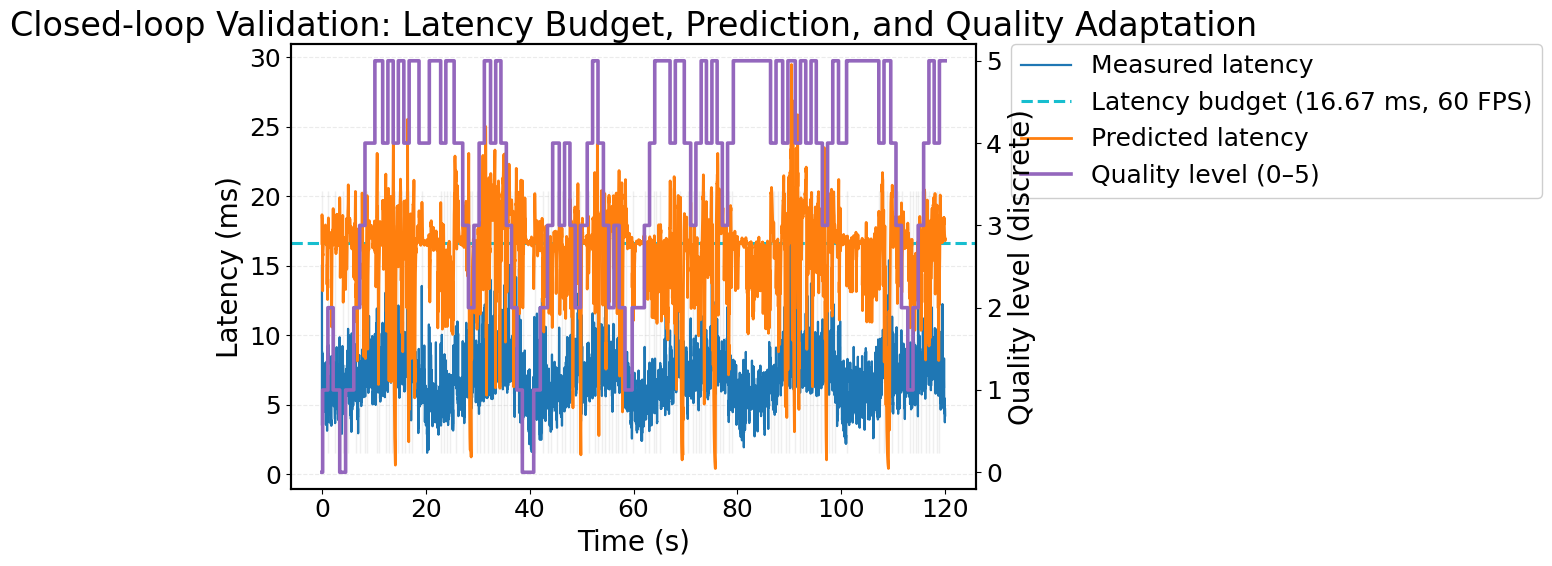

Saved: D:\PredictionUpdated_Dataset\Article _Results_Plots\closedloop_validation_qualitylevel.pdf
Run file: latency_dataset_20260205_220236.csv
Prediction column used: pred_latency_smooth_ms


In [50]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


ROOT = r"D:\PredictionUpdated_Dataset"
OUTDIR = os.path.join(ROOT, "D:\PredictionUpdated_Dataset\Article _Results_Plots")
os.makedirs(OUTDIR, exist_ok=True)

BUDGET_MS = 16.67
WINDOW_S = 120.0
RUN_INDEX = 0
SHOW_ACTION_MARKERS = True

# Visual tuning (INCREASED)
FIGSIZE = (16, 6)
DPI = 300
FONT_SIZE = 18
TITLE_SIZE = 24
AXIS_LABEL_SIZE = 20
TICK_SIZE = 18
LEGEND_SIZE = 18

LINEWIDTH_LAT = 1.6
LINEWIDTH_PRED = 2.0
LINEWIDTH_BUDGET = 2.2
LINEWIDTH_QUALITY = 2.6

ACTION_ALPHA = 0.12
MAX_ACTION_LINES = 120

plt.rcParams.update({
    "font.size": FONT_SIZE,
    "axes.titlesize": TITLE_SIZE,
    "axes.labelsize": AXIS_LABEL_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
})

# -----------------------------
# Load Closed-Loop run
# -----------------------------
files = sorted(glob.glob(os.path.join(ROOT, "Closed-Loop", "*.csv")))
if not files:
    raise RuntimeError("No Closed-Loop CSVs found.")

path = files[RUN_INDEX]
df = pd.read_csv(path)

# -----------------------------
# Build time axis
# -----------------------------
if "t_unity" in df.columns:
    t_raw = pd.to_numeric(df["t_unity"], errors="coerce").ffill().fillna(0)
elif "frame_idx" in df.columns:
    t_raw = pd.to_numeric(df["frame_idx"], errors="coerce").ffill().fillna(0)
else:
    t_raw = pd.Series(np.arange(len(df)), dtype=float)

df["t"] = t_raw - t_raw.iloc[0]
mask = df["t"] <= WINDOW_S
t = df.loc[mask, "t"].to_numpy()


# Signals
# -----------------------------
measured = pd.to_numeric(df.loc[mask, "measured_latency_ms"], errors="coerce").to_numpy()
quality = pd.to_numeric(df.loc[mask, "quality_level"], errors="coerce").to_numpy()

pred = None
pred_col = None
for c in ["pred_latency_smooth_ms", "pred_latency_ms"]:
    if c in df.columns:
        pred_col = c
        pred = pd.to_numeric(df.loc[mask, c], errors="coerce").to_numpy()
        break

action_times = np.array([])
if SHOW_ACTION_MARKERS and "action" in df.columns:
    action_times = t[df.loc[mask, "action"].astype(str) != "none"]


# Plot
fig, ax1 = plt.subplots(figsize=FIGSIZE)

# Colors
C_MEAS = "tab:blue"
C_PRED = "tab:orange"
C_BUDG = "tab:cyan"
C_QUAL = "tab:purple"
C_ACT  = "tab:gray"

# Latency (left axis)
ax1.plot(t, measured, color=C_MEAS, lw=LINEWIDTH_LAT,
         label="Measured latency", zorder=3)

ax1.axhline(BUDGET_MS, color=C_BUDG, ls="--",
            lw=LINEWIDTH_BUDGET,
            label="Latency budget (16.67 ms, 60 FPS)", zorder=2)

if pred is not None:
    ax1.plot(t, pred, color=C_PRED, lw=LINEWIDTH_PRED,
             label="Predicted latency", zorder=4)

ax1.set_xlabel("Time (s)", fontsize=AXIS_LABEL_SIZE)
ax1.set_ylabel("Latency (ms)", fontsize=AXIS_LABEL_SIZE)
ax1.grid(True, axis="y", linestyle="--", alpha=0.25)

# Make axes spines thicker (more visible)
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)

# Action markers
if action_times.size:
    stride = max(1, len(action_times) // MAX_ACTION_LINES)
    y0, y1 = np.nanmin(measured), np.nanmax(measured)
    for tt in action_times[::stride]:
        ax1.vlines(tt, y0, y1, color=C_ACT,
                   lw=1.0, alpha=ACTION_ALPHA, zorder=1)

# Quality level (right axis)
ax2 = ax1.twinx()
ax2.step(t, quality, where="post", color=C_QUAL,
         lw=LINEWIDTH_QUALITY,
         label="Quality level (0–5)", zorder=5)

ax2.set_ylabel("Quality level (discrete)", fontsize=AXIS_LABEL_SIZE)
ax2.set_ylim(-0.2, 5.2)

for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

# -----------------------------
# Legend (outside)
# -----------------------------
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

ax1.legend(
    h1 + h2,
    l1 + l2,
    loc="upper left",
    bbox_to_anchor=(1.05, 1.0),
    borderaxespad=0.0,
    frameon=True,
    framealpha=0.95
)

# Title
plt.title("Closed-loop Validation: Latency Budget, Prediction, and Quality Adaptation",
          fontsize=TITLE_SIZE)

fig.tight_layout(rect=[0, 0, 0.88, 1])

outpath = os.path.join(OUTDIR, "closedloop_validation_qualitylevel.pdf")
fig.savefig(outpath, dpi=DPI, bbox_inches="tight")

plt.show()
plt.close(fig)

print("Saved:", outpath)
print("Run file:", os.path.basename(path))
print("Prediction column used:", pred_col if pred_col else "None")


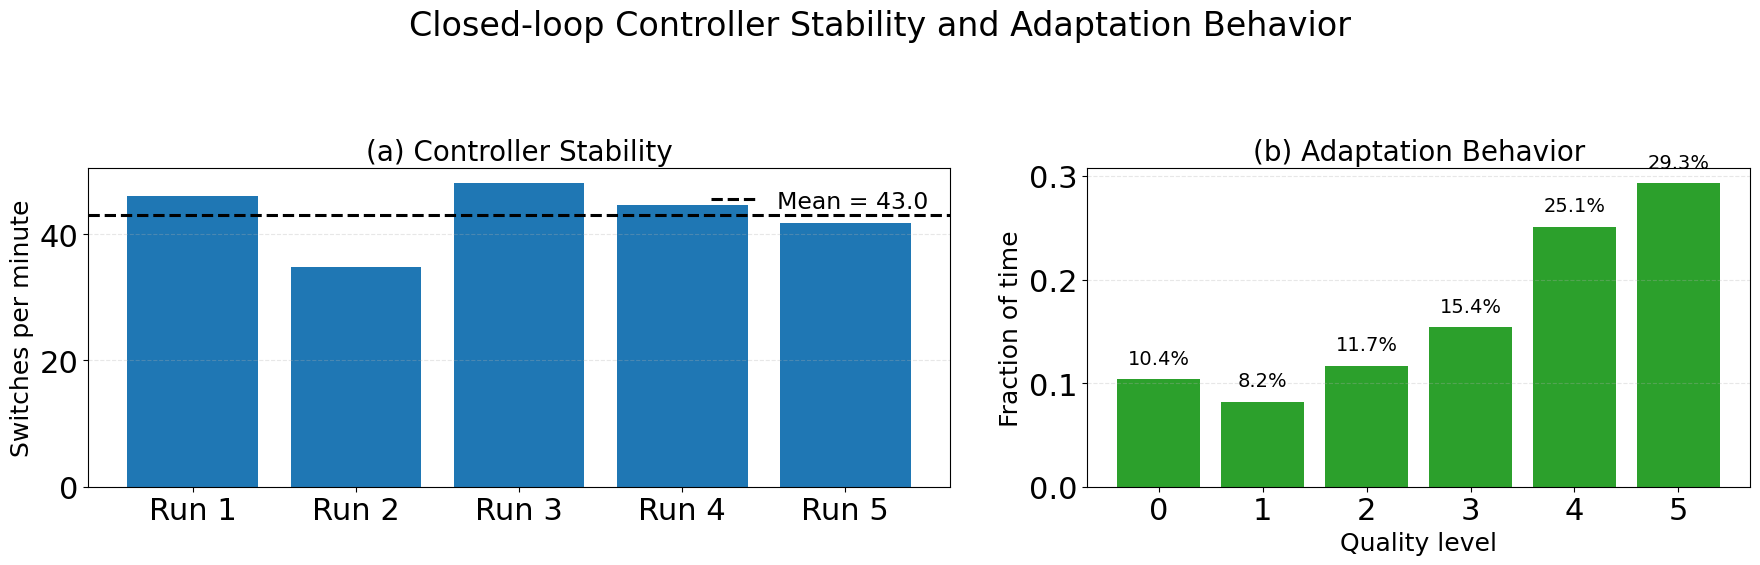

Saved: D:\PredictionUpdated_Dataset\Article _Results_Plots\closedloop_stability_and_quality_combined.pdf


In [58]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


ROOT = r"D:\PredictionUpdated_Dataset"
CLOSED_DIR = os.path.join(ROOT, "Closed-Loop")
OUTDIR = os.path.join(ROOT, "D:\PredictionUpdated_Dataset\Article _Results_Plots")
os.makedirs(OUTDIR, exist_ok=True)

QUALITY_COL = "quality_level"
DPI = 300


plt.rcParams.update({
    "font.size": 20,
    "axes.titlesize": 24,
    "axes.labelsize": 22,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 17,
})

# Locate CSVs
files = sorted(glob.glob(os.path.join(CLOSED_DIR, "*.csv")))
if not files:
    files = sorted(glob.glob(os.path.join(CLOSED_DIR, "**", "*.csv"), recursive=True))

if not files:
    raise RuntimeError("No Closed-Loop CSVs found.")


def add_time_axis(df: pd.DataFrame) -> pd.DataFrame:
    if "t_unity" in df.columns:
        t = pd.to_numeric(df["t_unity"], errors="coerce").ffill().fillna(0)
    elif "frame_idx" in df.columns:
        t = pd.to_numeric(df["frame_idx"], errors="coerce").ffill().fillna(0)
    else:
        t = pd.Series(np.arange(len(df)), dtype=float)
    df = df.copy()
    df["t"] = t - float(t.iloc[0])
    return df

# Compute metrics
rows = []
quality_time = {}

for run_id, f in enumerate(files, start=1):
    df = add_time_axis(pd.read_csv(f))
    if QUALITY_COL not in df.columns:
        continue

    t = pd.to_numeric(df["t"], errors="coerce").to_numpy(float)
    q = pd.to_numeric(df[QUALITY_COL], errors="coerce").to_numpy(float)

    good = np.isfinite(t) & np.isfinite(q)
    t, q = t[good], q[good]
    if len(t) < 2:
        continue

    switches = int(np.sum(np.diff(q) != 0))
    duration_s = float(t[-1] - t[0])
    spm = switches / max(duration_s / 60.0, 1e-9)

    rows.append({
        "run_id": run_id,
        "switches_per_min": spm
    })

    dt = np.diff(t, prepend=t[0])
    for qi, dti in zip(q, dt):
        if dti > 0 and np.isfinite(qi):
            qi = int(round(qi))
            quality_time[qi] = quality_time.get(qi, 0.0) + dti

df_runs = pd.DataFrame(rows)
if df_runs.empty:
    raise RuntimeError("No valid closed-loop runs processed.")


# COMBINED FIGURE (2 PANELS)
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(18, 6), gridspec_kw={"width_ratios": [1.3, 1]}
)

# ---- (a) Switching rate per run ----
x = np.arange(len(df_runs))
y = df_runs["switches_per_min"].to_numpy(float)
mean_y = float(np.mean(y))

ax1.bar(x, y, color="tab:blue")
ax1.axhline(mean_y, linestyle="--", linewidth=2.2, color="black",
            label=f"Mean = {mean_y:.1f}")

ax1.set_xticks(x)
ax1.set_xticklabels([f"Run {i}" for i in df_runs["run_id"]])
ax1.set_ylabel("Switches per minute", fontsize=18)
ax1.set_title("(a) Controller Stability", fontsize=20)
ax1.grid(axis="y", linestyle="--", alpha=0.3)
ax1.legend(frameon=False)

# ---- (b) Time spent in quality levels ----
qs = np.array(sorted(quality_time.keys()), dtype=int)
times = np.array([quality_time[q] for q in qs], dtype=float)
frac = times / times.sum()

ax2.bar([str(q) for q in qs], frac, color="tab:green")
ax2.set_xlabel("Quality level", fontsize=18)
ax2.set_ylabel("Fraction of time", fontsize=18)
ax2.set_title("(b) Adaptation Behavior", fontsize=20)
ax2.grid(axis="y", linestyle="--", alpha=0.3)

for i, v in enumerate(frac):
    ax2.text(i, v + 0.015, f"{100*v:.1f}%", ha="center", fontsize=14)

# -----------------------------
# Final layout
# -----------------------------
fig.suptitle(
    "Closed-loop Controller Stability and Adaptation Behavior",
    fontsize=24
)

fig.tight_layout(rect=[0, 0.02, 1, 0.92])

outpath = os.path.join(OUTDIR, "closedloop_stability_and_quality_combined.pdf")
fig.savefig(outpath, dpi=DPI)

plt.show()
plt.close(fig)

print("Saved:", outpath)


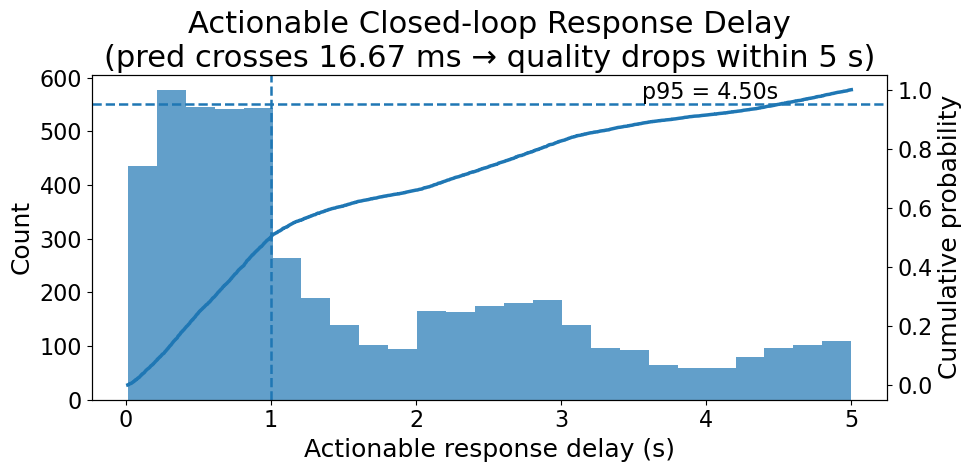

Saved: D:\PredictionUpdated_Dataset\Article _Results_Plots\closedloop_response_delay_hist_cdf.pdf


In [63]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# SETTINGS
# -----------------------------
ROOT = r"D:\PredictionUpdated_Dataset"
CLOSED_DIR = os.path.join(ROOT, "Closed-Loop")
OUTDIR = os.path.join(ROOT, "D:\PredictionUpdated_Dataset\Article _Results_Plots")
os.makedirs(OUTDIR, exist_ok=True)

BUDGET_MS = 16.67
MAX_RESPONSE_WINDOW = 5.0  # seconds

# Font sizes
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 22,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
})

# -----------------------------
# Collect delays from CSVs
# -----------------------------
files = sorted(glob.glob(os.path.join(CLOSED_DIR, "*.csv")))
if not files:
    raise RuntimeError("No Closed-Loop CSVs found.")

all_delays = []

for f in files:
    df = pd.read_csv(f)

    if "t_unity" not in df.columns or \
       "pred_latency_ms" not in df.columns or \
       "quality_level" not in df.columns:
        continue

    t = pd.to_numeric(df["t_unity"], errors="coerce").to_numpy(float)
    pred = pd.to_numeric(df["pred_latency_ms"], errors="coerce").to_numpy(float)
    q = pd.to_numeric(df["quality_level"], errors="coerce").to_numpy(float)

    good = np.isfinite(t) & np.isfinite(pred) & np.isfinite(q)
    t, pred, q = t[good], pred[good], q[good]

    for i in range(1, len(t)):
        # detect predicted crossing budget upward
        if pred[i-1] <= BUDGET_MS and pred[i] > BUDGET_MS:

            t0 = t[i]
            q0 = q[i]

            # look forward for quality drop
            for j in range(i+1, len(t)):
                if t[j] - t0 > MAX_RESPONSE_WINDOW:
                    break
                if q[j] < q0:
                    all_delays.append(t[j] - t0)
                    break

# Convert to numpy
delays = np.array(all_delays, dtype=float)
delays = delays[np.isfinite(delays)]

if len(delays) == 0:
    raise RuntimeError("No valid actionable delays detected.")

# -----------------------------
# Build CDF
# -----------------------------
xs = np.sort(delays)
ys = np.linspace(0, 1, len(xs), endpoint=True)

# -----------------------------
# Plot
# -----------------------------
fig, ax1 = plt.subplots(figsize=(10, 5))

# Histogram
ax1.hist(delays, bins=25, alpha=0.7)
ax1.set_xlabel("Actionable response delay (s)")
ax1.set_ylabel("Count")

# CDF
ax2 = ax1.twinx()
ax2.plot(xs, ys, linewidth=2.5)
ax2.set_ylabel("Cumulative probability")

# Reference lines
ax2.axhline(0.95, linestyle="--", linewidth=1.8)
ax1.axvline(1.0, linestyle="--", linewidth=1.8)

# p95 annotation
p95 = np.percentile(delays, 95)
ax2.text(p95, 0.95, f"p95 = {p95:.2f}s",
         ha="right", va="bottom", fontsize=16)

plt.title(
    "Actionable Closed-loop Response Delay\n"
    "(pred crosses 16.67 ms → quality drops within 5 s)"
)

fig.tight_layout()

out = os.path.join(OUTDIR, "closedloop_response_delay_hist_cdf.pdf")
plt.savefig(out, dpi=300)
plt.show()
plt.close()

print("Saved:", out)


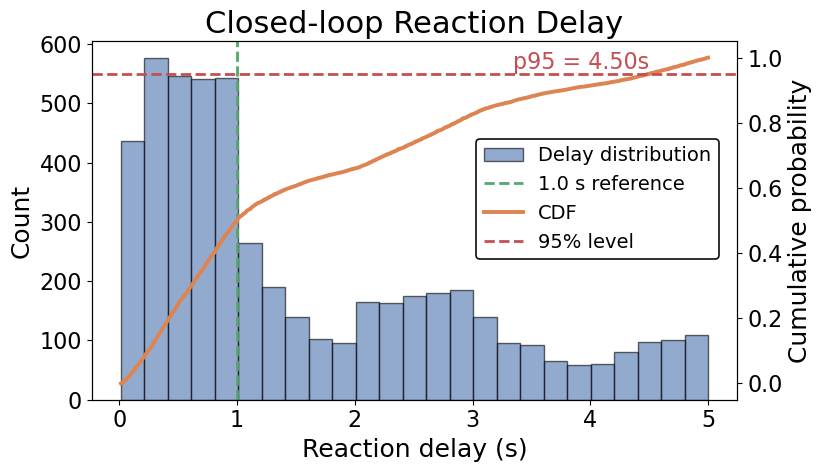

Saved: D:\PredictionUpdated_Dataset\Article _Results_Plots\closedloop_response_delay_hist_cdf.pdf
N delays = 5202 | p95 = 4.496 s


In [76]:
import os
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# SAVE DIRECTORY
# -----------------------------
OUTDIR = r"D:\PredictionUpdated_Dataset\Article _Results_Plots"
os.makedirs(OUTDIR, exist_ok=True)

# -----------------------------
# FONT SETTINGS
# -----------------------------
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 22,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 14,
})

# -----------------------------
# DATA
# -----------------------------
delays = np.array(all_delays, dtype=float)
delays = delays[np.isfinite(delays)]

if delays.size == 0:
    raise RuntimeError("No valid delay samples found in all_delays.")

# Sort for CDF
xs = np.sort(delays)
ys = np.linspace(0, 1, len(xs), endpoint=True)

p95 = np.percentile(delays, 95)

# -----------------------------
# COLORS (Distinct & Clean)
# -----------------------------
C_HIST = "#4C72B0"      # Blue
C_CDF = "#DD8452"       # Orange
C_REF = "#55A868"       # Green (1s line)
C_P95 = "#C44E52"       # Red (95% line)

# -----------------------------
# PLOT
# -----------------------------
fig, ax1 = plt.subplots(figsize=(10, 5))

# Histogram
ax1.hist(
    delays,
    bins=25,
    alpha=0.6,
    color=C_HIST,
    edgecolor="black",
    label="Delay distribution"
)
ax1.set_xlabel("Reaction delay (s)")
ax1.set_ylabel("Count")

# Vertical 1s reference
ax1.axvline(
    1.0,
    linestyle="--",
    linewidth=2,
    color=C_REF,
    label="1.0 s reference"
)

# CDF
ax2 = ax1.twinx()
ax2.plot(
    xs,
    ys,
    linewidth=2.8,
    color=C_CDF,
    label="CDF"
)
ax2.set_ylabel("Cumulative probability")

# Horizontal 95% line
ax2.axhline(
    0.95,
    linestyle="--",
    linewidth=2,
    color=C_P95,
    label="95% level"
)

# p95 annotation
ax2.text(
    p95,
    0.95,
    f"p95 = {p95:.2f}s",
    ha="right",
    va="bottom",
    fontsize=16,
    color=C_P95
)

# Title
plt.title(
    "Closed-loop Reaction Delay"
    
)

# -----------------------------
# LEGEND (Right-Center Outside)
# -----------------------------
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

legend = ax1.legend(
    h1 + h2,
    l1 + l2,
    loc="center left",
    bbox_to_anchor=(0.58, 0.56),  # right-center outside
    frameon=True,
    framealpha=0.95,
    edgecolor="black"
)

legend.get_frame().set_linewidth(1.2)

# Adjust layout to make space for legend
fig.tight_layout(rect=[0, 0, 0.85, 1])

# -----------------------------
# SAVE + SHOW
# -----------------------------
out = os.path.join(OUTDIR, "closedloop_response_delay_hist_cdf.pdf")
plt.savefig(out, dpi=300, bbox_inches="tight")

plt.show()
plt.close()

print("Saved:", out)
print(f"N delays = {len(delays)} | p95 = {p95:.3f} s")


Using load column: target_count


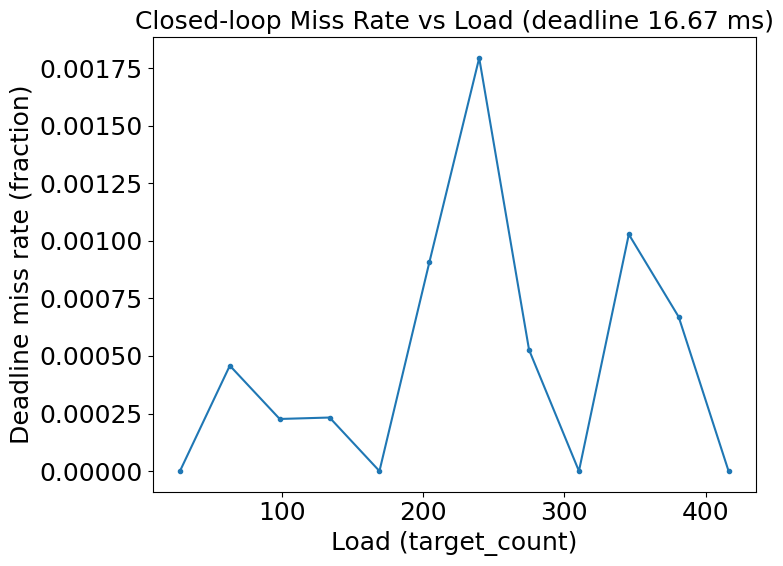

Saved plot: D:\PredictionUpdated_Dataset\Article _Results_Plots\closedloop_missrate_vs_load.pdf
Saved CSV: D:\PredictionUpdated_Dataset\Article _Results_Plots\closedloop_missrate_vs_load_bins.csv


In [97]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


ROOT = r"D:\PredictionUpdated_Dataset"
CLOSED_DIR = os.path.join(ROOT, "Closed-Loop")

# Save outputs here
SAVE_DIR = r"D:\PredictionUpdated_Dataset\Article _Results_Plots"
os.makedirs(SAVE_DIR, exist_ok=True)

BUDGET_MS = 16.67
NBINS = 15

# Match the small, simple look in the screenshot
plt.rcParams.update({
    "figure.figsize": (8, 6),
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize":18,
    "ytick.labelsize": 18,
    "lines.linewidth": 4,
})


# Load Closed-Loop CSVs

files = sorted(glob.glob(os.path.join(CLOSED_DIR, "*.csv")))
if not files:
    files = sorted(glob.glob(os.path.join(CLOSED_DIR, "**", "*.csv"), recursive=True))
if not files:
    raise RuntimeError("No CSVs found in Closed-Loop folder.")

# Pick a load column that exists
candidate_load_cols = ["target_count", "active_objects", "particle_budget"]
sample = pd.read_csv(files[0], nrows=50)
sample.columns = [str(c).strip() for c in sample.columns]

load_col = None
for c in candidate_load_cols:
    if c in sample.columns:
        load_col = c
        break
if load_col is None:
    raise RuntimeError("No load column found (target_count/active_objects/particle_budget).")

print("Using load column:", load_col)

# Aggregate all frames across runs
dfs = []
for f in files:
    df = pd.read_csv(f)
    df.columns = [str(c).strip() for c in df.columns]
    if "measured_latency_ms" not in df.columns or load_col not in df.columns:
        continue
    dfs.append(df[[load_col, "measured_latency_ms"]].copy())

if not dfs:
    raise RuntimeError("No valid CSVs with both load and measured_latency_ms.")

all_df = pd.concat(dfs, ignore_index=True)

load = pd.to_numeric(all_df[load_col], errors="coerce").to_numpy(float)
lat  = pd.to_numeric(all_df["measured_latency_ms"], errors="coerce").to_numpy(float)

good = np.isfinite(load) & np.isfinite(lat)
load, lat = load[good], lat[good]

if len(load) < 100:
    raise RuntimeError("Not enough valid samples for miss-rate vs load.")

miss = (lat > BUDGET_MS).astype(float)

# -----------------------------
# Bin by load and compute miss rate per bin
# -----------------------------
bins = np.linspace(np.min(load), np.max(load), NBINS + 1)
centers = 0.5 * (bins[:-1] + bins[1:])
miss_rate = np.full(NBINS, np.nan)
counts = np.zeros(NBINS, dtype=int)

for i in range(NBINS):
    m = (load >= bins[i]) & (load < bins[i + 1])
    counts[i] = int(np.sum(m))
    if counts[i] >= 30:
        miss_rate[i] = float(np.mean(miss[m]))

ok = np.isfinite(miss_rate)


# Plot
plt.figure()
plt.plot(centers[ok], miss_rate[ok], marker="o", linewidth=1.5, markersize=3)
plt.xlabel(f"Load ({load_col})")
plt.ylabel("Deadline miss rate (fraction)")
plt.title(f"Closed-loop Miss Rate vs Load (deadline {BUDGET_MS:.2f} ms)")
plt.tight_layout()

plot_out = os.path.join(SAVE_DIR, "closedloop_missrate_vs_load.pdf")
plt.savefig(plot_out, dpi=300)
plt.show()
plt.close()

print("Saved plot:", plot_out)


df_bins = pd.DataFrame({
    "load_center": centers,
    "miss_rate": miss_rate,
    "count": counts
})

csv_out = os.path.join(SAVE_DIR, "closedloop_missrate_vs_load_bins.csv")
df_bins.to_csv(csv_out, index=False)
print("Saved CSV:", csv_out)
